In [3]:
# implementing bayesian statistics on dataset phd-delays.csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import sklearn as sk
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
# reading the dataset
df = pd.read_csv('phd-delays.csv', delimiter=';')
df.columns = ['B3_difference_extra','E4_having_child','E21_sex','E22_Age','E22_Age_Squared']

def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

standardize(df['B3_difference_extra'])
standardize(df['E22_Age'])
standardize(df['E22_Age_Squared'])
#split the dataset
X = df[['E22_Age','E22_Age_Squared']]
y = df['B3_difference_extra']
import sklearn.model_selection as skm
X_train, X_test, y_train, y_test = skm.train_test_split(X, y, test_size=0.2, random_state=42)
y_ = y_train
y_train = y
X_ = X_train
X_train = X


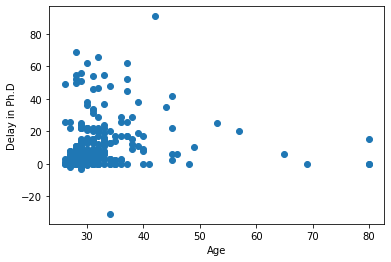

In [5]:
# visualise data
plt.scatter(X['E22_Age'],y)
plt.xlabel('Age')
plt.ylabel('Delay in Ph.D')
plt.show()

In [6]:

# creating a model for y = b_intercept + b_0*age + b_1*age^2 + e
mu_ = 0
sd = 100
with pm.Model() as model:
    # mu_ = pm.Uniform('mean_gen' , lower = -10, upper = 20)
    b_intercept = pm.Normal('b_intercept',mu = -35, sigma=20)
    b_0 = pm.Normal('b_0' , mu = 2.5 , sigma=5)
    b_1 = pm.Normal('b_1' , mu = -0.03, sigma = 0.01)
    eps = pm.InverseGamma('eps', 0.5, 0.5)
    sg = pm.HalfNormal('sg' , sigma=1)
    likelihood = pm.Normal('y', mu=b_intercept + b_0*X_train['E22_Age'] + b_1*X_train['E22_Age_Squared']+eps, sigma=sg, observed=y_train)

    
    # perform inference
    trace = pm.sample(5000,init='adapt_diag', target_accept=0.99, cores=4,tune = 2000)
    # prior_checks = pm.sample_prior_predictive(samples = 300)



Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sg, eps, b_1, b_0, b_intercept]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 202 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.


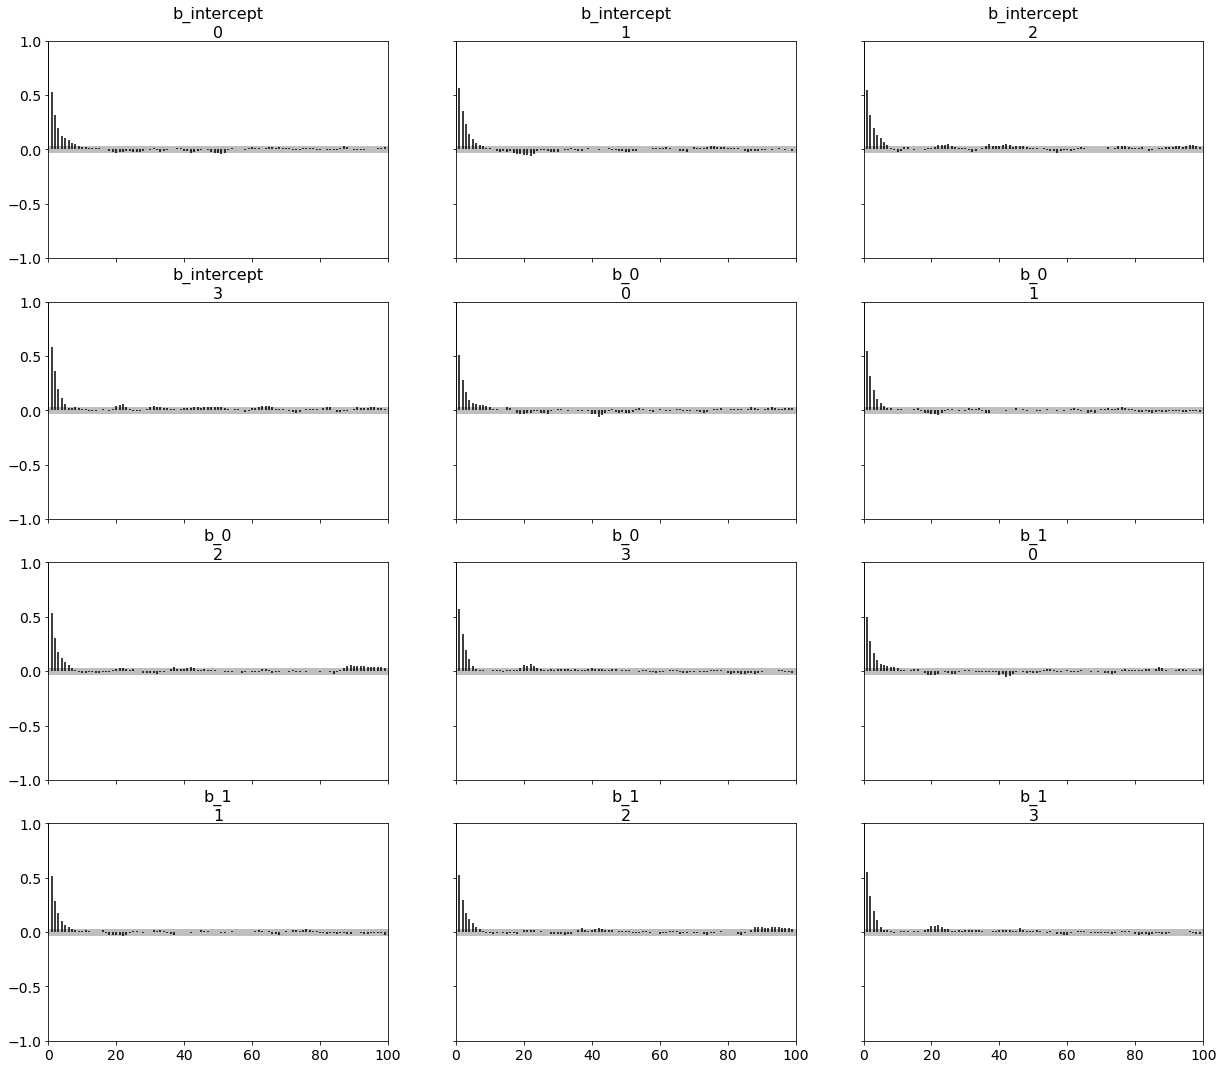

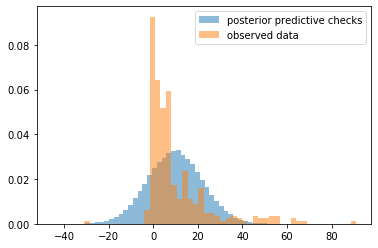

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_intercept,-47.722,9.199,-65.882,-31.399,0.129,0.092,5180.0,6775.0,1.0
b_0,2.541,0.398,1.770,3.263,0.005,0.004,5484.0,7212.0,1.0
b_1,-0.025,0.004,-0.033,-0.017,0.000,0.000,5544.0,7589.0,1.0
eps,3.096,4.875,0.063,10.875,0.073,0.056,7170.0,6032.0,1.0
sg,11.716,0.337,11.060,12.328,0.003,0.002,10644.0,8896.0,1.0


In [7]:
pm.autocorrplot(trace, var_names=['b_intercept','b_0','b_1'])
plt.show()
# perform prior predictive checks on the model
with model:
    prior_checks = pm.sample_prior_predictive(samples = 300)
    posterior_checks = pm.sample_posterior_predictive(trace, samples =300)


# histo of the posterior predictive
plt.hist(posterior_checks['y'].flatten(), bins=50, density=True, alpha=0.5, label='posterior predictive checks')
plt.hist(y_train, bins=50, density=True, alpha=0.5, label='observed data')
plt.legend(loc=0)
plt.show()

az.summary(trace)


In [8]:
# finding MAP parameter values for the model
map_estimate = pm.find_MAP(model=model)
print(map_estimate)

# perform accuracy test on this test data with MAP parameter values

y_pred = map_estimate['b_intercept'] + map_estimate['b_0']*X_test['E22_Age'] + map_estimate['b_1']*X_test['E22_Age_Squared']+map_estimate['eps']
# print(y_pred)
# print(y_test)
print(sk.metrics.mean_squared_error(y_test, y_pred))




{'b_intercept': array(-35.02104053), 'b_0': array(2.07642817), 'b_1': array(-0.0201467), 'eps_log__': array(-1.10557563), 'sg_log__': array(2.45786061), 'eps': array(0.33102028), 'sg': array(11.67979715)}
186.6759363716567


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


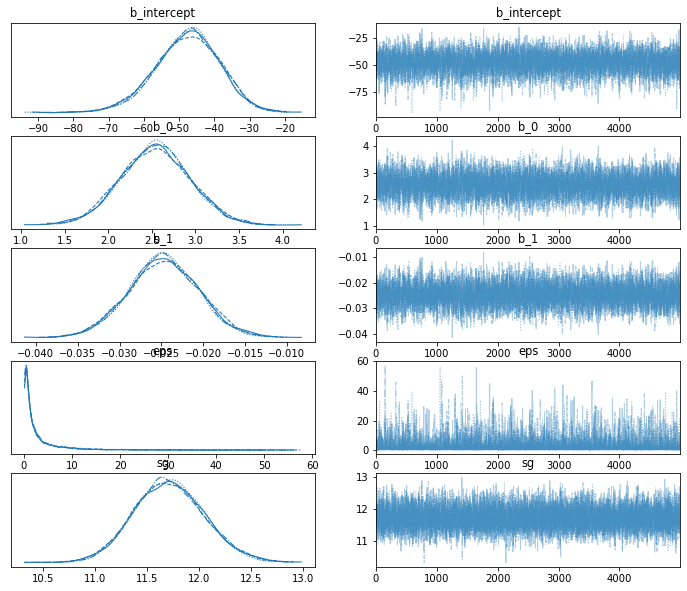

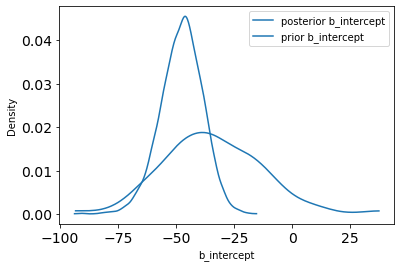

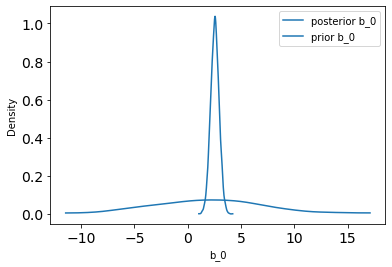

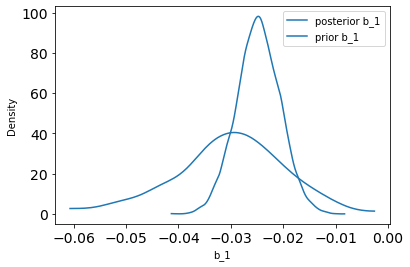

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_intercept,-47.722,9.199,-65.882,-31.399,0.129,0.092,5180.0,6775.0,1.0
b_0,2.541,0.398,1.770,3.263,0.005,0.004,5484.0,7212.0,1.0
b_1,-0.025,0.004,-0.033,-0.017,0.000,0.000,5544.0,7589.0,1.0
eps,3.096,4.875,0.063,10.875,0.073,0.056,7170.0,6032.0,1.0
sg,11.716,0.337,11.060,12.328,0.003,0.002,10644.0,8896.0,1.0


In [9]:
# plots of the trace runs performed discarding first 2000 iterations
# trace = trace[2000:]

az.plot_trace(trace)
plt.show()


# compare b_intercept posterior distribution with the prior distribution with colours
az.plot_kde(trace['b_intercept'], label='posterior b_intercept')
az.plot_kde(prior_checks['b_intercept'], label='prior b_intercept')
plt.xlabel('b_intercept')
plt.ylabel('Density')
plt.legend()
plt.show()

# compare b_0 
az.plot_kde(trace['b_0'], label='posterior b_0')
az.plot_kde(prior_checks['b_0'], label='prior b_0')
plt.xlabel('b_0')
plt.ylabel('Density')
plt.legend()
plt.show()

# compare b_1
az.plot_kde(trace['b_1'], label='posterior b_1')
az.plot_kde(prior_checks['b_1'], label='prior b_1')
plt.xlabel('b_1')
plt.ylabel('Density')
plt.legend()
plt.show()


az.summary(trace) #summarise our trace run with MCMC

184.8051854108854


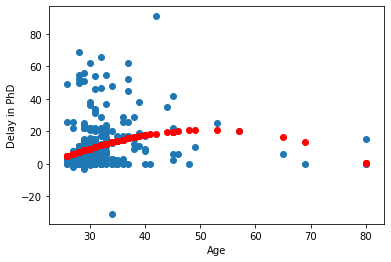

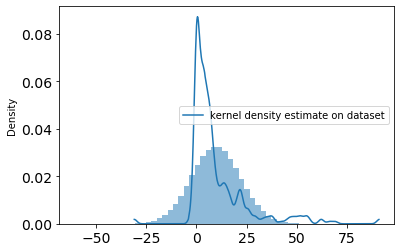

In [10]:
with model:
    ppc = az.from_pymc3(posterior_predictive=pm.sample_posterior_predictive(trace))

posterior_samples = ppc.posterior_predictive['y'].values.flatten()


# comparing with standard linear regression
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(sk.metrics.mean_squared_error(y_test, y_pred))

# plotting line of best fit
plt.scatter(X_train['E22_Age'],y_train)
plt.scatter(X_train['E22_Age'],reg.predict(X_train),color='red', label='predicted line of reg fit')
plt.xlabel('Age')
plt.ylabel('Delay in PhD')
plt.show()
# plot r_hat for all parameters
az.plot_kde(y,label = 'kernel density estimate on dataset') 
plt.hist(posterior_samples, bins=50, density=True, alpha=0.5, label='posterior predictive checks')
plt.ylabel('Density')
plt.show()